In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
import sys

sys.path.append("/gdrive/My Drive")
sys.path.append('..')
sys.path.append('../..')

# Configuration variables: task to run, paths to datasets, ...

In [0]:
ball_train_data_path = "/gdrive/My Drive/bouncing_balls_training_data.mat"
ball_test_data_path = "/gdrive/My Drive/bouncing_balls_testing_data.mat"

save_results_path = "/gdrive/My Drive"

# Utility and processing functions


In [0]:
# imports
import glob
import pandas as pd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import numpy as np

import copy
import os
import pickle
import time
from random import shuffle
import copy
import pickle
import random
import numpy as np



def get_bouncing_split_sets(future=5):
    data_train = pickle.load(open(ball_train_data_path, "rb"))["Data"]
    data_test = pickle.load(open(ball_test_data_path, "rb"))["Data"]


    horizon = 30 - future

    train_len = int(0.75 * len(data_train))

    def shift_array(data):
      return np.swapaxes(np.swapaxes(data, 1, 2), 3, 2)

    def form_data(in_data):
        data_out_x = copy.deepcopy(in_data)
        data_out_y = []

        for i in range(len(in_data)):
            data_out_x[i] = in_data[i].reshape((30, 30, 30))

            data_out_y.append(data_out_x[i][-1, :, :])
            data_out_x[i] = data_out_x[i][:-future, :, :]
        return data_out_x, data_out_y

    pre_train_x, pre_train_y = form_data(data_train)
    test_x, test_y = form_data(data_test)

    train_x, train_y = pre_train_x[:train_len], pre_train_y[:train_len]
    valid_x, valid_y = pre_train_x[train_len:], pre_train_y[train_len:]

    train_x, train_y = np.stack(train_x, axis=0), np.expand_dims(np.stack(train_y, axis=0), 1)
    valid_x, valid_y = np.stack(valid_x, axis=0), np.expand_dims(np.stack(valid_y, axis=0), 1)
    test_x, test_y = np.stack(test_x, axis=0), np.expand_dims(np.stack(test_y, axis=0), 1)

    return shift_array(train_x), shift_array(train_y), shift_array(valid_x), shift_array(valid_y), shift_array(test_x), shift_array(test_y)

def get_errors(predicted, test_y, horizon, min_val, max_val):
    total_nodes = predicted.shape[1] * predicted.shape[2]

    errs = np.zeros((predicted.shape[1], predicted.shape[2], horizon))
    mape = np.zeros((predicted.shape[1], predicted.shape[2], horizon))
    mae = np.zeros((predicted.shape[1], predicted.shape[2], horizon))

    for i in range(test_y.shape[0]):
        denorm_truth = test_y[i, :, :, :] * (max_val - min_val) + min_val
        denorm_pred = predicted[i, :, :, :] * (max_val - min_val) + min_val

        mape += np.abs((denorm_truth - denorm_pred) / denorm_truth)
        errs += (denorm_truth - denorm_pred) ** 2
        mae += np.abs(denorm_pred - denorm_truth)
    errs = np.sum(errs, axis=2) / test_y.shape[0]

    rmse = np.sqrt(np.sum(errs) / total_nodes)
    mape = np.sum(np.sum(mape, axis=2) / test_y.shape[0]) / total_nodes * 100
    mae = np.sum((np.sum(mae, axis=2) / test_y.shape[0])) / total_nodes

    return rmse, mape, mae

# Define models classes

In [6]:
import keras
from keras import Input, Model, metrics
from keras.layers import Conv2D

from keras import Input, Model, metrics
from keras.layers import Conv2D, Dense, Activation, Reshape, Flatten, LocallyConnected2D
from keras.layers import MaxPooling2D, LSTM, Concatenate

class CNN():
    def __init__(self, train_x, train_y, valid_x, valid_y, test_x, test_y, layers=None):
        self.input_dim, self.look_back, self.horizon =  (train_x[0].shape[1], train_x[0].shape[2]), train_x[0].shape[-1], 1
        self.train_x, self.train_y, self.valid_x, self.valid_y, self.test_x, self.test_y = train_x, train_y, valid_x, valid_y, test_x, test_y
        self.layers = layers

    def get_model(self):
        I1 = Input(shape=(self.input_dim[0], self.input_dim[1], self.look_back))

        if self.layers is None:
            Conved = Conv2D(30, kernel_size=5, activation='relu', padding="same")(I1)
            Conved = Conv2D(30, kernel_size=4, activation='relu', padding="same")(Conved)
            Conved = Conv2D(30, kernel_size=3, activation='relu', padding="same")(Conved)
        else:
            for idx, layer in enumerate(self.layers):
                if idx == 0:
                    Conved = Conv2D(layer[1], kernel_size=layer[0], activation='relu', padding="same")(I1)
                else:
                    Conved = Conv2D(layer[1], kernel_size=layer[0], activation='relu', padding="same")(Conved)

        Sing = Conv2D(self.horizon, kernel_size=1, padding="same")(Conved)
        model = Model(inputs=[I1], outputs=[Sing])
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=[metrics.mse])

        self.model = model
        return self.model

    def train(self, epochs=1):
        hist = self.model.fit(self.train_x, self.train_y, validation_data=(self.valid_x, self.valid_y), epochs=epochs,
                              batch_size=200, verbose=2)
        return hist

    def predict(self, data):
        predicted = self.model.predict(data)
        return predicted

############ =================================================================================== ######################
class LICNN():
    def __init__(self, train_x, train_y, valid_x, valid_y, test_x, test_y, learnable_inputs_count, layers=None):
        self.input_dim, self.look_back, self.horizon = (train_x[0].shape[1], train_x[0].shape[2]), train_x[0].shape[-1], 1
        self.train_x, self.train_y, self.valid_x, self.valid_y, self.test_x, self.test_y = train_x, train_y, valid_x, valid_y, test_x, test_y
        self.learnable_inputs_count = learnable_inputs_count
        self.layers = layers

    def get_model(self):
        I1 = Input(shape=(self.input_dim[0], self.input_dim[1], self.look_back))

        # To implement learnable inputs, we use auxillary input...
        I2 = Input(shape=(self.input_dim[0],self.input_dim[1], 1))
        # ...that receives a matrix of 1s and implements locally connected layer without biases with a 1x1 kernel.
        C1 = LocallyConnected2D(self.learnable_inputs_count, kernel_size=(1, 1), input_shape=(self.input_dim[0], self.input_dim[1], 1),
                                bias_initializer='zeros', use_bias=False)(I2)
        
        # Finally, we concatinate real input with the learnable input. 
        Merged1 = Concatenate(-1)([I1, C1])

        if self.layers is None:
            Conved = Conv2D(30, kernel_size=5, activation='relu', padding="same")(Merged1)
            Conved = Conv2D(30, kernel_size=4, activation='relu', padding="same")(Conved)
            Conved = Conv2D(30, kernel_size=3, activation='relu', padding="same")(Conved)
        else:
            for idx, layer in enumerate(self.layers):
                if idx == 0:
                    Conved = Conv2D(layer[1], kernel_size=layer[0], activation='relu', padding="same")(Merged1)
                else:
                    Conved = Conv2D(layer[1], kernel_size=layer[0], activation='relu', padding="same")(Conved)

        Sing = Conv2D(self.horizon, kernel_size=1, padding="same")(Conved)

        model = Model(inputs=[I1, I2], outputs=Sing)
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=[metrics.mse])
        self.model = model
        return self.model

    def train(self, epochs = 1):
        hist = self.model.fit(self.train_x, self.train_y, validation_data=(self.valid_x, self.valid_y), epochs=epochs, batch_size=200, verbose=2)
        return hist
    def predict(self, data):
        predicted = self.model.predict(data)
        return predicted
# ================================================================================================================

Using TensorFlow backend.


# Experiment driver

In [0]:
def run_experiment():
  train_x, train_y, valid_x, valid_y, test_x, test_y = get_bouncing_split_sets(future = 5)
  print(train_x.shape)
  # spatial dimension
  input_dim = (train_x.shape[1], train_x.shape[2])
  look_back = train_x.shape[3]

  train_ones = np.ones((train_x.shape[0], train_x.shape[1], train_x.shape[2], 1))
  valid_ones = np.ones((valid_x.shape[0], valid_x.shape[1], valid_x.shape[2], 1))
  test_ones = np.ones((test_x.shape[0], test_x.shape[1], test_x.shape[2], 1))

  rand_noise_in = np.expand_dims(np.random.random((train_x.shape[1], train_x.shape[2], 2))*2 - 1, 0)

  train_rand = np.repeat(rand_noise_in, train_x.shape[0],axis=0)
  valid_rand = np.repeat(rand_noise_in, valid_x.shape[0],axis=0)
  test_rand = np.repeat(rand_noise_in, test_x.shape[0],axis=0)

  coords= np.zeros((1,30,30, 2))
  for i in range(30):
      for j in range(30):
          coords[0, i, j, 1] = j / train_x.shape[2]
          coords[0, i, j, 0] = i / train_x.shape[1]

  train_coords = np.repeat(coords, train_x.shape[0],axis=0)
  valid_coords = np.repeat(coords, valid_x.shape[0],axis=0)
  test_coords =  np.repeat(coords, test_x.shape[0],axis=0)

 
  models = [
      {
          "name": "CNN",
          "skip": True,
          "model": CNN([train_x], train_y, [valid_x], valid_y, [test_x], test_y, layers=[(20, 22), (10, 10)])
      },
      {
        "name": "LI CNN",
        "skip": True,
        # 2 learnable inputs are used
        "model": LICNN([train_x, train_ones], train_y, [valid_x, valid_ones], valid_y, [test_x, test_ones], test_y, 2,layers=[(20, 20), (10,10)])
      },
      {
        "name": "CoordConv",
        "skip": False,
        # coordinates are concatinated with the input
        "model": CNN([np.concatenate( (train_x, train_coords), axis=-1)], train_y, [np.concatenate( (valid_x, valid_coords), axis=-1)], valid_y,
                                     [np.concatenate( (test_x, test_coords), axis=-1)],  test_y, layers=[(20, 21), (10, 10)])
      },
      { 
        "name": "RandomConv",
        "skip": True,
        # random noise is concatinated with the input
        "model": CNN([np.concatenate( (train_x, train_rand), axis=-1)], train_y, [np.concatenate( (valid_x, valid_rand), axis=-1)], valid_y,
                                     [np.concatenate( (test_x, test_rand), axis=-1)],  test_y, layers=[(20, 21), (10, 10)])
      },
  ]

  epochs_count = 100
  extra_text = ""

  # for clearier code the random matrix passed to RandomConv is fixed here, but was regenerated in each experiment  
  repeat_exp_count = 5

  for exp_iter in range(repeat_exp_count):
      print("Starting {} / {} experiments batch".format(exp_iter, repeat_exp_count))
      for model in models:
          if "skip" in model and model["skip"] is True:
              print("Skipping {} ".format(model["name"]))
              continue
          # initialize
          model["model"].get_model()
          model["model"].model.summary()
          print("Training {} model, with {} learnable parameters".format(model["name"], model["model"].model.count_params()))

          train_error, valid_error, test_error = [], [], []

          for epoch in range(epochs_count):
              hist = model["model"].train()

              predicted_valid = model["model"].predict(model["model"].valid_x) # this corresponds to the first testing set in the paper
              predicted_test = model["model"].predict(model["model"].test_x)         

              valid_rmse, valid_mape, valid_mae = get_errors(predicted_valid, model["model"].valid_y, 1, 0, 1)
              test_rmse, test_mape, test_mae = get_errors(predicted_test, model["model"].test_y, 1, 0, 1)

              print("Model - {} , epoch {} / {}.".format(model["name"], epoch + 1, epochs_count))
              print("Test RMSE - {}, MAPE - {}, MAE - {}".format(test_rmse, test_mape, test_mae))
              
              test_error.append((test_rmse, test_mape, test_mae))
              valid_error.append((valid_rmse, valid_mape, valid_mae))
              train_error.append((hist.history["loss"]))

          folder = "{}/results/synthetic/bouncing_ball/".format(save_results_path)
          if not os.path.isdir(folder):
              os.makedirs(folder)

          file_name = "{}/{}_{}_{}_{}".format(folder,
                                                    model["name"],
                                                    model["model"].model.count_params(),
                                                    epochs_count,
                                                    str(time.ctime()).replace(" ", "_").replace(":", "-"))
          pickle.dump({"name": model["name"],
                      "learnable_parameters": model["model"].model.count_params(),
                      "horizon": 1,
                      "predict_horizon": 1,
                      "look_back": look_back,
                      "summary": model["model"].model.to_json(),
                      "model_descriptor": model["model"].model.to_json(),
                      "test_error": test_error,
                      "time": time.ctime(),
                      "valid_error": valid_error,
                      "train_error": train_error},
                      open(file_name, "wb"))
      # write the results to the file

In [34]:
run_experiment()

(1500, 30, 30, 25)
Starting 0 / 5 experiments batch
Skipping CNN 
Skipping LI CNN 
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 30, 30, 27)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 30, 30, 21)        226821    
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 30, 30, 10)        21010     
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 30, 30, 1)         11        
Total params: 247,842
Trainable params: 247,842
Non-trainable params: 0
_________________________________________________________________
Training CoordConv model, with 247842 learnable parameters
Train on 1500 samples, validate on 500 samples
Epoch 1/1
 - 1s - loss: 0.0434 - mean_squared_error: 0.0434 -

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in true_divide


Model - CoordConv , epoch 1 / 100.
Test RMSE - 0.18355873470111575, MAPE - inf, MAE - 0.06472045912436208
Train on 1500 samples, validate on 500 samples
Epoch 1/1
 - 1s - loss: 0.0334 - mean_squared_error: 0.0334 - val_loss: 0.0329 - val_mean_squared_error: 0.0329
Model - CoordConv , epoch 2 / 100.
Test RMSE - 0.18240068853224375, MAPE - inf, MAE - 0.07339491872682209
Train on 1500 samples, validate on 500 samples
Epoch 1/1
 - 1s - loss: 0.0326 - mean_squared_error: 0.0326 - val_loss: 0.0319 - val_mean_squared_error: 0.0319
Model - CoordConv , epoch 3 / 100.
Test RMSE - 0.17902388374427966, MAPE - inf, MAE - 0.07035664462629763
Train on 1500 samples, validate on 500 samples
Epoch 1/1
 - 1s - loss: 0.0315 - mean_squared_error: 0.0315 - val_loss: 0.0309 - val_mean_squared_error: 0.0309
Model - CoordConv , epoch 4 / 100.
Test RMSE - 0.17627206018644573, MAPE - inf, MAE - 0.08296699113179848
Train on 1500 samples, validate on 500 samples
Epoch 1/1
 - 1s - loss: 0.0304 - mean_squared_error:

# Results

 RandomConv has 247842 learnable params.
 LI CNN has 237841 learnable params.
 CoordConv has 247842 learnable params.
 CNN has 242043 learnable params.


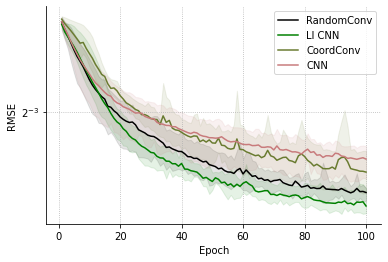

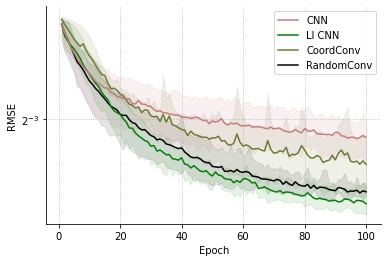

In [36]:
# import importlib
# importlib.reload(matplotlib)
import glob
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np

import constants
import seaborn as sns
from itertools import cycle
sns.set_palette("cubehelix")

cycol = cycle(sns.color_palette())

def read_folder(folder_path):
    os.chdir(folder_path)

    results = {}
    for file in reversed(sorted(glob.glob("*"))):
        res = pickle.load(open(file, "rb"))
        if "learnable_maps_count" in res:
            res["name"] = "{} #learn maps-{}".format(res["name"], res["learnable_maps_count"])
        if res["name"] not in results:

            results[res["name"]] = []

        results[res["name"]].append(res)

    return results
folder = "{}/results/synthetic/bouncing_ball/".format(save_results_path)
results = read_folder(folder)
colors = [next(cycol) for _ in range(0, 10)]
colors[0] = "black"
colors[1] = "green"
iter = 0

for key,val in results.items():
    # aggregate
    train_errs,valid_errs,test_mape_errs, test_mse_errs = None,None,None,None
    learnable_params = []

    abstract_name = None
    for run in val:
        if len(run["train_error"]) != 100:
            continue
        abstract_name = run["name"]
        learnable_params.append(run["learnable_parameters"])
        valid_errs = np.array(run["valid_error"])[:,0][None].T if valid_errs is None else np.hstack((valid_errs,np.array(run["valid_error"])[:,0][None].T ))
        test_mse_errs = np.array(run["test_error"])[:,0][None].T if test_mse_errs is None else np.hstack((test_mse_errs,np.array(run["test_error"])[:,0][None].T))
    learnable_params = np.mean(learnable_params).astype(int)
    print(" {} has {} learnable params.".format(key, learnable_params))
    def get_batch_stats(batch):
        mean_batch = np.mean(batch, axis=-1)

        min_batch = np.min(batch, axis=-1)
        max_batch = np.max(batch,axis=-1)

        return mean_batch, min_batch, max_batch

    plt.figure(1)
    mean_test, min_test, max_test = get_batch_stats(test_mse_errs)

    mean_valid, min_valid, max_valid = get_batch_stats(valid_errs)

    # test error
    plt.fill_between(np.linspace(1,mean_test.shape[0],mean_test.shape[0],endpoint=True),min_test,max_test,color=colors[iter%len(colors)],alpha=0.1)
    plt.semilogy(np.linspace(1,mean_test.shape[0],mean_test.shape[0],endpoint=True),mean_test,  color=colors[iter%len(colors)], label=abstract_name,basey = 2)
    # validation error
    plt.figure(2)
    plt.fill_between(np.linspace(1, mean_valid.shape[0], mean_valid.shape[0], endpoint=True), min_valid, max_valid,
                     color=colors[iter % len(colors)], alpha=0.1)
    plt.semilogy(np.linspace(1, mean_valid.shape[0], mean_valid.shape[0], endpoint=True), mean_valid, color=colors[iter % len(colors)],label=abstract_name,basey = 2)
    iter+=1
plt.figure(1)
plt.grid(linestyle=":")

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: len(t[0])))
ax.legend(handles, labels)

plt.xlabel("Epoch")
plt.ylabel("RMSE")

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.figure(2)
plt.grid(linestyle=":")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("RMSE")


plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

display(plt.figure(2))
display(plt.figure(1))

plt.close()
plt.figure(2)
plt.close()